In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import datetime, timedelta
from pathlib import Path
import sys

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

from prediction_engine.auction_predictor import AuctionPredictor

pd.options.display.max_columns = None
pd.options.display.width = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [2]:
items = pd.read_csv('../data/items.csv')
print("Items shape:", items.shape)

n_items = len(items)
item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0 
item_to_index[1] = 1  
print(f"Number of unique items: {n_items}")

time_left_mapping = {
    'VERY_LONG': 48,
    'LONG': 12,
    'MEDIUM': 2,
    'SHORT': 0.5
}

Items shape: (11655, 13)
Number of unique items: 11655


In [3]:
def load_auctions_from_sample(data_dir):
    file_info = {}
    auction_appearances = {}

    for root, dirs, files in os.walk(data_dir):
        for filename in tqdm(files):
            filepath = os.path.join(root, filename)
            date = datetime.strptime(filename.split('.')[0], '%Y%m%dT%H')
            file_info[filepath] = date

    file_info = {k: v for k, v in sorted(file_info.items(), key=lambda item: item[1])}
    
    all_auctions = []
    
    for filepath in list(file_info.keys()):
        with open(filepath, 'r') as f:
            try:
                json_data = json.load(f)
                
                if 'auctions' not in json_data:
                    print(f"File {filepath} does not contain 'auctions' key, skipping.")
                    continue
                
                auction_data = json_data['auctions']
                timestamp = file_info[filepath]
                
                for auction in auction_data:
                    auction_id = auction['id']
                    auction['timestamp'] = timestamp.strftime("%Y-%m-%d %H:%M:%S")
                    
                    if auction_id not in auction_appearances:
                        auction_appearances[auction_id] = {'first': timestamp, 'last': timestamp}
                    else:
                        auction_appearances[auction_id]['last'] = timestamp
                
                all_auctions.extend(auction_data)
            except json.JSONDecodeError as e:
                print(f"Error loading file {filepath}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error loading file {filepath}: {e}")
                continue

    return all_auctions, auction_appearances

def process_auction_data(auctions, auction_appearances, prediction_time):
    auctions_by_item = {}
    hours_on_sale = {}
    auction_ids_by_item = {}
    hours_since_first_appearance_values = [] 

    for auction in auctions:
        auction_id = auction['id']
        item_id = auction['item']['id']
        time_left_numeric = time_left_mapping.get(auction['time_left'], 0) / 48.0
        bid = np.log1p(auction['bid'] / 10000) / 15.0
        buyout = np.log1p(auction['buyout'] / 10000) / 15.0
        quantity = auction['quantity'] / 200
        item_index = item_to_index.get(item_id, 1)
        timestamp = datetime.strptime(auction['timestamp'], "%Y-%m-%d %H:%M:%S")

        if timestamp != prediction_time:
            continue

        hours_since_first_appearance = (prediction_time - auction_appearances[auction_id]['first']).total_seconds() / 3600
        hours_since_first_appearance_values.append(hours_since_first_appearance)  
        hours_since_first_appearance_normalized = hours_since_first_appearance / 48.0
        hours_on_sale[auction_id] = (auction_appearances[auction_id]['last'] - auction_appearances[auction_id]['first']).total_seconds() / 3600

        datetime_str = prediction_time.strftime("%Y-%m-%d %H:%M:%S")

        processed_auction = [
            bid, 
            buyout,  
            quantity, 
            item_index,
            time_left_numeric, 
            hours_since_first_appearance_normalized
        ]
        
        if item_index not in auctions_by_item:
            auctions_by_item[item_index] = []
            auction_ids_by_item[item_index] = []

        auctions_by_item[item_index].append(processed_auction)
        auction_ids_by_item[item_index].append(auction_id)

    if hours_since_first_appearance_values:
        print(f"Hours since first appearance statistics: Min: {min(hours_since_first_appearance_values)}, Max: {max(hours_since_first_appearance_values)}, Mean: {np.mean(hours_since_first_appearance_values)}")
    
    return auctions_by_item, auction_ids_by_item, hours_on_sale

prediction_time = datetime.strptime("2024-09-27 00:00:00", "%Y-%m-%d %H:%M:%S")

data_dir = '../data/sample/'
auction_data, auction_appearances = load_auctions_from_sample(data_dir)
auctions_by_item, auction_ids_by_item, hours_on_sale = process_auction_data(auction_data, auction_appearances, prediction_time)
print(f"Processed auctions for {len(auctions_by_item)} different items.")
print(f"Example of processed auctions for an item: {auctions_by_item[list(auctions_by_item.keys())[0]][0]}")
print(f"Example of hours_on_sale for an auction: {list(hours_on_sale.items())[0]}")

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 115439.56it/s]


Hours since first appearance statistics: Min: 0.0, Max: 49.0, Mean: 19.749417040358743
Processed auctions for 1286 different items.
Example of processed auctions for an item: [0.3707159547772722, 0.3732281305998917, 0.005, 9544, 0.010416666666666666, 0.9791666666666666]
Example of hours_on_sale for an auction: (1395664463, 49.0)


In [5]:
model = AuctionPredictor(
    n_items=len(item_to_index),             
    input_size=5,                   
    encoder_hidden_size=256,
    decoder_hidden_size=256,
    item_index=3,                   
    embedding_size=128,
    dropout_p=0.2,
    bidirectional=False
).to(device)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

model_path = '../models/checkpoint_epoch_0_iter_9999.pt'
checkpoint = torch.load(model_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  
print('Pre-trained RNN model loaded successfully.')

Number of model parameters: 3490049
Pre-trained RNN model loaded successfully.


In [6]:
def evaluate_rnn_with_inspection_and_mae(model, auctions_by_item, auction_ids_by_item, hours_on_sale, prediction_time):
    all_predictions = []
    all_actual_values = []

    print(f"Total number of items: {len(auctions_by_item)}")
    print(f"Total number of auctions: {sum(len(auctions) for auctions in auctions_by_item.values())}")

    if hours_on_sale:
        print(f"Hours on sale statistics: Min: {min(hours_on_sale.values())}, Max: {max(hours_on_sale.values())}, Mean: {np.mean(list(hours_on_sale.values()))}")
    else:
        print("No 'hours_on_sale' data to calculate statistics.")

    for item_idx, auctions in auctions_by_item.items():
        if not auctions:
            continue
        
        auctions_np = np.array(auctions)
        X = torch.tensor(auctions_np, dtype=torch.float32).to(device)
        X = X.unsqueeze(0)  
        
        with torch.no_grad():
            predictions = model(X)

        auction_ids = auction_ids_by_item.get(item_idx, [])  
        actual_values = [hours_on_sale.get(auction_id, 0) for auction_id in auction_ids]  

        if len(predictions.squeeze(0)) == len(actual_values):
            all_predictions.extend(predictions.squeeze((0, -1)).cpu().numpy())
            all_actual_values.extend(actual_values)
        else:
            print(f"Skipping item {item_idx} due to size mismatch: {len(predictions.squeeze(0))} predictions vs {len(actual_values)} actual values.")

    if not all_predictions:
        print("No valid auctions were processed. Check your data.")
        return None, None

    print(f"Number of predictions: {len(all_predictions)}")
    print(f"Number of actual values: {len(all_actual_values)}")
    print(f"Predictions statistics: Min: {min(all_predictions)}, Max: {max(all_predictions)}, Mean: {np.mean(all_predictions)}")
    print(f"Actual values statistics: Min: {min(all_actual_values)}, Max: {max(all_actual_values)}, Mean: {np.mean(all_actual_values)}")

    return all_predictions, all_actual_values

def calculate_mae(all_predictions, all_actual_values):
    if len(all_predictions) == 0 or len(all_actual_values) == 0:
        print("No valid data for MAE calculation.")
        return None
    
    all_predictions = np.array(all_predictions)
    all_actual_values = np.array(all_actual_values)
    
    mae = mean_absolute_error(all_actual_values, all_predictions)
    
    return mae

all_predictions, all_actual_values = evaluate_rnn_with_inspection_and_mae(
    model, auctions_by_item, auction_ids_by_item, hours_on_sale, prediction_time
)

if all_predictions is not None and all_actual_values is not None:
    rnn_mae = calculate_mae(all_predictions, all_actual_values)
    if rnn_mae is not None:
        print(f'RNN Model MAE: {rnn_mae}')
    else:
        print('Evaluation failed due to lack of valid data.')
else:
    print('No predictions were made.')

Total number of items: 1286
Total number of auctions: 5575
Hours on sale statistics: Min: 1.0, Max: 50.0, Mean: 42.21793721973094
Number of predictions: 5575
Number of actual values: 5575
Predictions statistics: Min: 10.575900077819824, Max: 48.938377380371094, Mean: 39.660438537597656
Actual values statistics: Min: 1.0, Max: 50.0, Mean: 42.21793721973094
RNN Model MAE: 7.259411082930629


In [7]:
df = pd.DataFrame({
    'target': all_actual_values,
    'prediction': all_predictions
})

df.sample(10)

,target,prediction
1312,49.0,42.474525
1592,19.0,30.814537
359,49.0,30.223389
3686,25.0,36.119541
1248,49.0,48.716122
88,49.0,47.565117
4146,25.0,40.359035
4811,25.0,27.622843
1151,49.0,48.344444
5334,4.0,21.115879


In [8]:
df.describe()

,target,prediction
count,5575.000000,5575.000000
mean,42.217937,39.660439
std,11.772803,8.612375
min,1.000000,10.575900
25%,38.000000,32.679440
50%,49.000000,41.941307
75%,49.000000,47.608368
max,50.000000,48.938377


In [9]:
df.query('target < 10').sample(10)

,target,prediction
3389,4.0,22.130846
5360,5.0,20.171604
4950,8.0,28.736618
3392,7.0,25.637228
3778,6.0,23.587248
4238,7.0,31.377491
5014,5.0,39.232315
704,6.0,35.885880
3685,6.0,36.696148
3521,8.0,27.922083


<Axes: >

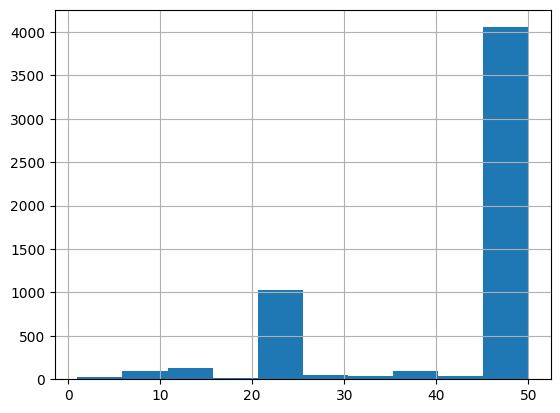

In [10]:
df['target'].hist()

<Axes: >

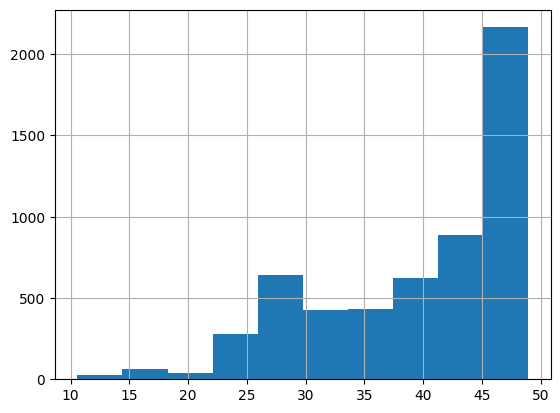

In [11]:
df['prediction'].hist()

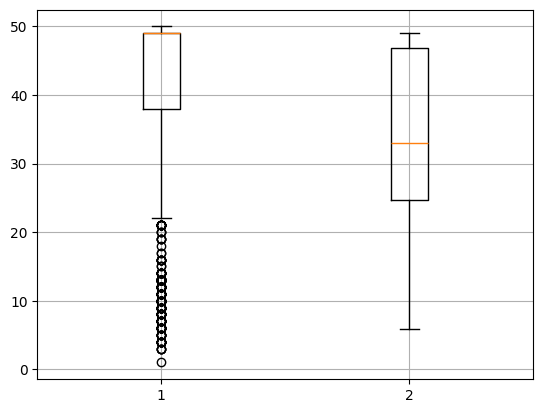

In [25]:
plt.boxplot(df)
plt.grid()
plt.show()

In [13]:
df.to_csv('../generated/predictions.csv')

In [46]:
df['error'] = np.abs(df['target'] - df['prediction'])
df[df.target <= 20].sample(10)

,target,prediction,error
4224,13.0,14.409211,1.409211
1966,4.0,26.513374,22.513374
5195,13.0,46.304241,33.304241
4869,13.0,32.607265,19.607265
1406,9.0,21.524797,12.524797
4230,13.0,12.021943,0.978057
2186,6.0,29.075911,23.075911
1453,20.0,26.945475,6.945475
2849,13.0,26.623114,13.623114
4823,11.0,13.085117,2.085117


In [ ]:
corr_matrix = df_val[['bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor','hours_on_sale', 'prediction', 'error']].corr()

corr_matrix = corr_matrix[['prediction', 'hours_on_sale', 'error']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Prediction and Hours on Sale - MAE 5.54')
plt.show()